In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Used to save and load models. Speculated to be faster for large models in
#https://machinelearningmastery.com/save-gradient-boosting-models-xgboost-python/
import joblib
#XGBoost itself
import xgboost as xgb

Note that classes/tools from sklearn are imported when needed

In [3]:
from IML2018_tools import *

In [4]:
!python --version

Python 3.6.4 :: Anaconda, Inc.


In [5]:
!ls

conda_env.list				      __pycache__
EDA_and_xgboost.ipynb			      README.md
Evaluate_Models.ipynb			      Test_file_content.ipynb
Feature_Extraction.ipynb		      test_full_Nhardest5.pickle
gs1_2it_ClfOnly_FullSampleTrained.joblib.dat  test_pred_2.npy
gs1_2it.joblib.dat			      test_pred.npy
gs1.joblib.dat				      test_pred_X.npy
gs2.joblib.dat				      train10000_mod.pickle
IML2018_tools.py			      train10000.npy
IML_challenge_2018.zip			      train_full_Nhardest5.pickle
Prepare_Submission.ipynb


In [6]:
#train_file_name = 'train10000.npy'
train_file_name = 'train_full_Nhardest5.pickle'

Read in the file properly for different file formats

In [7]:
train_df = loadInputAsDF(train_file_name, n = None)

In [8]:
train_df.shape

(1042167, 53)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042167 entries, 0 to 1042166
Data columns (total 53 columns):
genjet_sd_m              1042167 non-null float32
recojet_pt               1042167 non-null float32
recojet_eta              1042167 non-null float32
recojet_phi              1042167 non-null float32
recojet_m                1042167 non-null float32
recojet_sd_pt            1042167 non-null float32
recojet_sd_eta           1042167 non-null float32
recojet_sd_phi           1042167 non-null float32
recojet_sd_m             1042167 non-null float32
n_constituents           1042167 non-null int32
sum_charge               1042167 non-null float64
sum_Eem                  1042167 non-null float64
sum_Ehad                 1042167 non-null float64
constituents_pt_0        1042167 non-null float32
constituents_pt_1        1042167 non-null float32
constituents_pt_2        1042167 non-null float32
constituents_pt_3        1042167 non-null float32
constituents_pt_4        1042167 non-nu

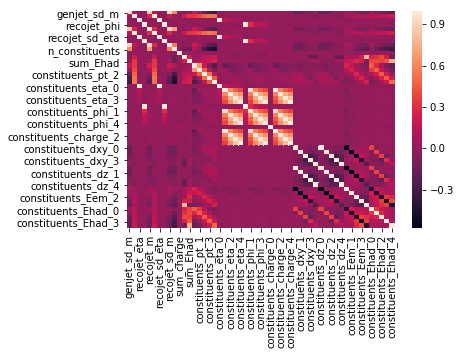

In [10]:
sns.heatmap(train_df.corr())

## EDA

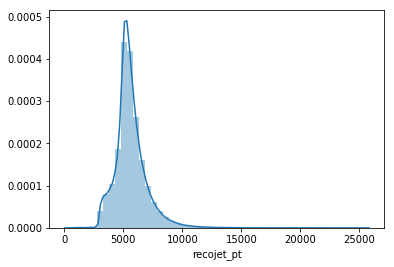

In [11]:
sns.distplot(train_df['recojet_pt'])

In [ ]:
#for var in ['recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m',
#       'recojet_sd_pt', 'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m',
#       'n_constituents']:
#    print(var)
#    sns.jointplot(x='genjet_sd_m', y=var, data=train_df, kind='hex')

### Drop some columns

In [12]:
dropColumns(train_df, printColumns=True)

Index(['genjet_sd_m', 'recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m',
       'recojet_sd_pt', 'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m',
       'n_constituents', 'sum_charge', 'sum_Eem', 'sum_Ehad',
       'constituents_pt_0', 'constituents_pt_1', 'constituents_pt_2',
       'constituents_pt_3', 'constituents_pt_4', 'constituents_eta_0',
       'constituents_eta_1', 'constituents_eta_2', 'constituents_eta_3',
       'constituents_eta_4', 'constituents_phi_0', 'constituents_phi_1',
       'constituents_phi_2', 'constituents_phi_3', 'constituents_phi_4',
       'constituents_charge_0', 'constituents_charge_1',
       'constituents_charge_2', 'constituents_charge_3',
       'constituents_charge_4', 'constituents_dxy_0', 'constituents_dxy_1',
       'constituents_dxy_2', 'constituents_dxy_3', 'constituents_dxy_4',
       'constituents_dz_0', 'constituents_dz_1', 'constituents_dz_2',
       'constituents_dz_3', 'constituents_dz_4', 'constituents_Eem_0',
       'constituent

### Split and normalise

In [13]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('genjet_sd_m', axis=1), train_df['genjet_sd_m'] , test_size=0.30, random_state=314)

## Run only if you want to keep jets between 5 and 7 TeV in the test sample

In [16]:
#Xtest5to7 = (X_test['recojet_pt'] > 5000) & (X_test['recojet_pt'] < 7000)

In [17]:
#X_test = X_test[Xtest5to7]
#y_test = y_test[Xtest5to7]

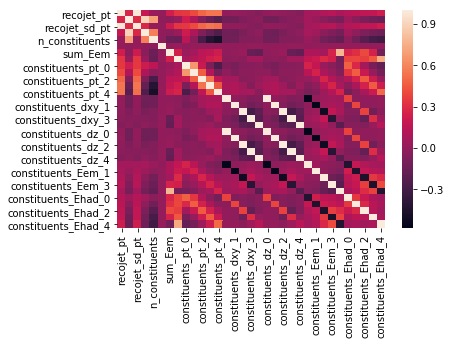

In [18]:
sns.heatmap(X_train.corr())

In [19]:
from sklearn.decomposition import PCA
pca_trans = PCA()
pca_trans.fit(X_train)
X_train_pca = pca_trans.transform(X_train)
X_test_pca = pca_trans.transform(X_test)

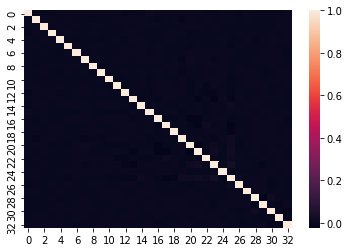

In [20]:
sns.heatmap(pd.DataFrame(X_test_pca).corr())

# XGBoost regressor

## Build the XGBoost model and define the metric

In [21]:
#preliminary parameters. will be fine-tuned in the GridSearch
xgb_params = {'max_depth': 5, 'learning_rate':0.1, 'n_estimators':100,
              'silent':1, 'random_state': 314, 'seed': 314, 'n_jobs':4}

In [22]:
clf = xgb.XGBRegressor(**xgb_params)

## Read GS, if needed

In [23]:
gs1 = joblib.load('gs1.joblib.dat')
gs1_2it = joblib.load('gs1_2it.joblib.dat')
gs2 = joblib.load('gs2.joblib.dat')

/home/mlisovyi/anaconda2/envs/coursera_aml_yandex/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Run XGBoost with the chosen optimal parameters

In [25]:
x = gs1.best_estimator_.get_params()
del x['n_job']
x['n_jobs'] = 4

In [26]:
clf.set_params(**x)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=3, missing=nan, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=314,
       reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=314,
       silent=1, subsample=1)

In [27]:
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=evaluate_loss_xgb,
        verbose=False)

/home/mlisovyi/atlas/IML2018/IML_challenge_2018/IML2018_tools.py:81: RuntimeWarning: divide by zero encountered in true_divide
  ratio = predictions / t


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=3, missing=nan, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=314,
       reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=314,
       silent=1, subsample=1)

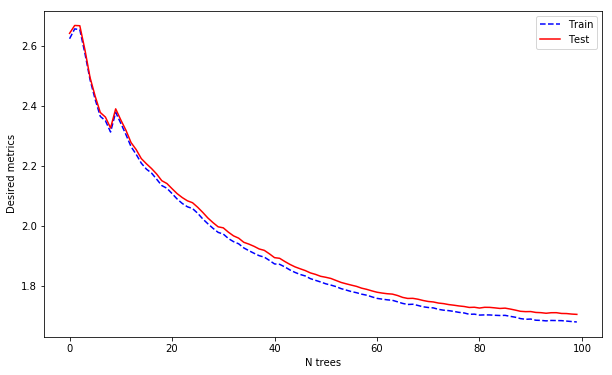

In [28]:
plotClfPerfEvolution(clf)

## Same as above, but for the fine-tuned classifier

In [29]:
x = gs1_2it.best_estimator_.get_params()
del x['n_job']
x['n_jobs'] = 4

In [30]:
clf.set_params(**x)
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=evaluate_loss_xgb,
        verbose=True)

[0]	validation_0-rmse:296.048	validation_1-rmse:296.392	validation_0-xxx:2.22464	validation_1-xxx:2.25466


/home/mlisovyi/atlas/IML2018/IML_challenge_2018/IML2018_tools.py:81: RuntimeWarning: divide by zero encountered in true_divide
  ratio = predictions / t


[1]	validation_0-rmse:268.808	validation_1-rmse:269.309	validation_0-xxx:2.18749	validation_1-xxx:2.21925
[2]	validation_0-rmse:245.243	validation_1-rmse:245.972	validation_0-xxx:2.21526	validation_1-xxx:2.24617
[3]	validation_0-rmse:223.412	validation_1-rmse:224.361	validation_0-xxx:2.15213	validation_1-xxx:2.18086
[4]	validation_0-rmse:204.017	validation_1-rmse:205.193	validation_0-xxx:2.08487	validation_1-xxx:2.11302
[5]	validation_0-rmse:186.746	validation_1-rmse:188.228	validation_0-xxx:2.04286	validation_1-xxx:2.07893
[6]	validation_0-rmse:171.453	validation_1-rmse:173.249	validation_0-xxx:2.00641	validation_1-xxx:2.04314
[7]	validation_0-rmse:157.913	validation_1-rmse:160.035	validation_0-xxx:1.98377	validation_1-xxx:2.0185
[8]	validation_0-rmse:145.969	validation_1-rmse:148.462	validation_0-xxx:1.95924	validation_1-xxx:1.99933
[9]	validation_0-rmse:135.981	validation_1-rmse:138.891	validation_0-xxx:2.00298	validation_1-xxx:2.04322
[10]	validation_0-rmse:126.721	validation_1-rms

[78]	validation_0-rmse:64.0798	validation_1-rmse:80.7095	validation_0-xxx:1.43454	validation_1-xxx:1.53615
[79]	validation_0-rmse:64.0044	validation_1-rmse:80.7071	validation_0-xxx:1.43278	validation_1-xxx:1.53506
[80]	validation_0-rmse:63.9072	validation_1-rmse:80.7011	validation_0-xxx:1.43288	validation_1-xxx:1.53452
[81]	validation_0-rmse:63.8405	validation_1-rmse:80.7068	validation_0-xxx:1.43012	validation_1-xxx:1.53135
[82]	validation_0-rmse:63.7131	validation_1-rmse:80.707	validation_0-xxx:1.42794	validation_1-xxx:1.52952
[83]	validation_0-rmse:63.6289	validation_1-rmse:80.7104	validation_0-xxx:1.42704	validation_1-xxx:1.52773
[84]	validation_0-rmse:63.5631	validation_1-rmse:80.7079	validation_0-xxx:1.42641	validation_1-xxx:1.52807
[85]	validation_0-rmse:63.4937	validation_1-rmse:80.7062	validation_0-xxx:1.42495	validation_1-xxx:1.52794
[86]	validation_0-rmse:63.4432	validation_1-rmse:80.7092	validation_0-xxx:1.42391	validation_1-xxx:1.52689
[87]	validation_0-rmse:63.3446	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.001, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=4, nthread=None, objective='reg:linear',
       random_state=314, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=314, silent=1, subsample=1)

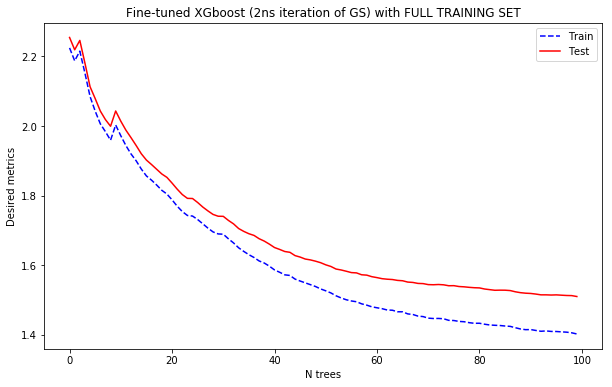

In [31]:
plotClfPerfEvolution(clf, title='Fine-tuned XGboost (2ns iteration of GS) with FULL TRAINING SET')

In [32]:
#joblib.dump(clf, 'gs1_2it_ClfOnly_FullSampleTrained.joblib.dat')

## Try to continue training

In [33]:
clf_cont = xgb.XGBRegressor(**clf.get_params())
clf_cont.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=evaluate_loss_xgb,
        verbose=True, xgb_model=clf.get_booster())

[0]	validation_0-rmse:62.3972	validation_1-rmse:80.7094	validation_0-xxx:1.40054	validation_1-xxx:1.50898


/home/mlisovyi/atlas/IML2018/IML_challenge_2018/IML2018_tools.py:81: RuntimeWarning: divide by zero encountered in true_divide
  ratio = predictions / t


[1]	validation_0-rmse:62.3446	validation_1-rmse:80.7101	validation_0-xxx:1.39999	validation_1-xxx:1.50832
[2]	validation_0-rmse:62.2781	validation_1-rmse:80.7111	validation_0-xxx:1.39851	validation_1-xxx:1.50616
[3]	validation_0-rmse:62.1982	validation_1-rmse:80.716	validation_0-xxx:1.39791	validation_1-xxx:1.50538
[4]	validation_0-rmse:62.1148	validation_1-rmse:80.7152	validation_0-xxx:1.39611	validation_1-xxx:1.50544
[5]	validation_0-rmse:62.0418	validation_1-rmse:80.7196	validation_0-xxx:1.39275	validation_1-xxx:1.50317
[6]	validation_0-rmse:61.975	validation_1-rmse:80.718	validation_0-xxx:1.3912	validation_1-xxx:1.50247
[7]	validation_0-rmse:61.9139	validation_1-rmse:80.7182	validation_0-xxx:1.3891	validation_1-xxx:1.50052
[8]	validation_0-rmse:61.8215	validation_1-rmse:80.7174	validation_0-xxx:1.3881	validation_1-xxx:1.49977
[9]	validation_0-rmse:61.7438	validation_1-rmse:80.7227	validation_0-xxx:1.38682	validation_1-xxx:1.50011
[10]	validation_0-rmse:61.6861	validation_1-rmse:80.

[78]	validation_0-rmse:58.0685	validation_1-rmse:80.7673	validation_0-xxx:1.32276	validation_1-xxx:1.46338
[79]	validation_0-rmse:58.0243	validation_1-rmse:80.7682	validation_0-xxx:1.32188	validation_1-xxx:1.46277
[80]	validation_0-rmse:57.993	validation_1-rmse:80.7667	validation_0-xxx:1.32103	validation_1-xxx:1.4624
[81]	validation_0-rmse:57.9393	validation_1-rmse:80.7709	validation_0-xxx:1.32147	validation_1-xxx:1.46353
[82]	validation_0-rmse:57.8898	validation_1-rmse:80.7751	validation_0-xxx:1.3201	validation_1-xxx:1.4626
[83]	validation_0-rmse:57.881	validation_1-rmse:80.7736	validation_0-xxx:1.31953	validation_1-xxx:1.46236
[84]	validation_0-rmse:57.8214	validation_1-rmse:80.7761	validation_0-xxx:1.3182	validation_1-xxx:1.46181
[85]	validation_0-rmse:57.7612	validation_1-rmse:80.7782	validation_0-xxx:1.31803	validation_1-xxx:1.46155
[86]	validation_0-rmse:57.7355	validation_1-rmse:80.7766	validation_0-xxx:1.31799	validation_1-xxx:1.46091
[87]	validation_0-rmse:57.7081	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.001, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=4, nthread=None, objective='reg:linear',
       random_state=314, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=314, silent=1, subsample=1)

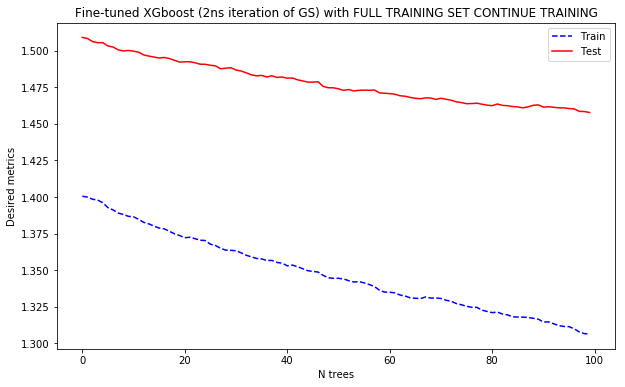

In [34]:
plotClfPerfEvolution(clf_cont, title='Fine-tuned XGboost (2ns iteration of GS) with FULL TRAINING SET CONTINUE TRAINING')

## Same as above, but for the fine-tuned classifier and pT range applier to the evaluation¶

In [35]:
gs1_2it_Clf = joblib.load('gs1_2it_ClfOnly_FullSampleTrained.joblib.dat')
gs1_2it_Clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0.001,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 11,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 314,
 'reg_alpha': 1e-05,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 314,
 'silent': 1,
 'subsample': 1}

In [36]:
gs1_2it_Clf.set_params(**{'n_jobs': 4})

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.001, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=4, nthread=None, objective='reg:linear',
       random_state=314, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=314, silent=1, subsample=1)

In [37]:
gs1_2it_Clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=evaluate_loss_xgb,
        verbose=True)

[0]	validation_0-rmse:296.048	validation_1-rmse:296.392	validation_0-xxx:2.22464	validation_1-xxx:2.25466


/home/mlisovyi/atlas/IML2018/IML_challenge_2018/IML2018_tools.py:81: RuntimeWarning: divide by zero encountered in true_divide
  ratio = predictions / t


[1]	validation_0-rmse:268.808	validation_1-rmse:269.309	validation_0-xxx:2.18749	validation_1-xxx:2.21925
[2]	validation_0-rmse:245.243	validation_1-rmse:245.972	validation_0-xxx:2.21526	validation_1-xxx:2.24617
[3]	validation_0-rmse:223.412	validation_1-rmse:224.361	validation_0-xxx:2.15213	validation_1-xxx:2.18086
[4]	validation_0-rmse:204.017	validation_1-rmse:205.193	validation_0-xxx:2.08487	validation_1-xxx:2.11302
[5]	validation_0-rmse:186.746	validation_1-rmse:188.228	validation_0-xxx:2.04286	validation_1-xxx:2.07893
[6]	validation_0-rmse:171.453	validation_1-rmse:173.249	validation_0-xxx:2.00641	validation_1-xxx:2.04314
[7]	validation_0-rmse:157.913	validation_1-rmse:160.035	validation_0-xxx:1.98377	validation_1-xxx:2.0185
[8]	validation_0-rmse:145.969	validation_1-rmse:148.462	validation_0-xxx:1.95924	validation_1-xxx:1.99933
[9]	validation_0-rmse:135.981	validation_1-rmse:138.891	validation_0-xxx:2.00298	validation_1-xxx:2.04322
[10]	validation_0-rmse:126.721	validation_1-rms

[78]	validation_0-rmse:64.0798	validation_1-rmse:80.7095	validation_0-xxx:1.43454	validation_1-xxx:1.53615
[79]	validation_0-rmse:64.0044	validation_1-rmse:80.7071	validation_0-xxx:1.43278	validation_1-xxx:1.53506
[80]	validation_0-rmse:63.9072	validation_1-rmse:80.7011	validation_0-xxx:1.43288	validation_1-xxx:1.53452
[81]	validation_0-rmse:63.8405	validation_1-rmse:80.7068	validation_0-xxx:1.43012	validation_1-xxx:1.53135
[82]	validation_0-rmse:63.7131	validation_1-rmse:80.707	validation_0-xxx:1.42794	validation_1-xxx:1.52952
[83]	validation_0-rmse:63.6289	validation_1-rmse:80.7104	validation_0-xxx:1.42704	validation_1-xxx:1.52773
[84]	validation_0-rmse:63.5631	validation_1-rmse:80.7079	validation_0-xxx:1.42641	validation_1-xxx:1.52807
[85]	validation_0-rmse:63.4937	validation_1-rmse:80.7062	validation_0-xxx:1.42495	validation_1-xxx:1.52794
[86]	validation_0-rmse:63.4432	validation_1-rmse:80.7092	validation_0-xxx:1.42391	validation_1-xxx:1.52689
[87]	validation_0-rmse:63.3446	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.001, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=4, nthread=None, objective='reg:linear',
       random_state=314, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=314, silent=1, subsample=1)

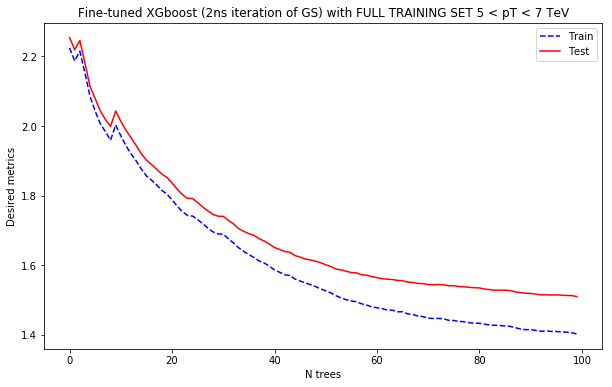

In [38]:
plotClfPerfEvolution(gs1_2it_Clf, 'Fine-tuned XGboost (2ns iteration of GS) with FULL TRAINING SET 5 < pT < 7 TeV')

## Same original tune, butfit on PCA-transformed inputs

In [40]:
x = gs1_2it.best_estimator_.get_params()
del x['n_job']
x['n_jobs'] = 4

In [ ]:
clf.set_params(**x)
clf.fit(X_train_pca, y_train, 
        eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)],
        eval_metric=evaluate_loss_xgb,
        verbose=False)

/home/mlisovyi/atlas/IML2018/IML_challenge_2018/IML2018_tools.py:81: RuntimeWarning: divide by zero encountered in true_divide
  ratio = predictions / t


In [ ]:
plotClfPerfEvolution(clf, title='PCA transform of inputs')

## Default XGBoost parameters

In [ ]:
clf_def = xgb.XGBRegressor(**xgb_params)

clf_def.fit(X_train_pca, y_train, 
        eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)],
        eval_metric=evaluate_loss_xgb,
        verbose=False)

In [ ]:
plotClfPerfEvolution(clf_def, title='PCA transform of inputs DEFAULT XGBoost')

## PCA train

In [ ]:
gs2 = joblib.load('gs2.joblib.dat')

In [ ]:
gs2.best_estimator_.get_params()

In [ ]:
clf_pca_hyp = xgb.XGBRegressor(**gs2.best_estimator_.get_params())
clf_pca_hyp.set_params(**{'max_depth': 7})

clf_pca_hyp.fit(X_train_pca, y_train, 
        eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)],
        eval_metric=evaluate_loss_xgb,
        verbose=False)

In [ ]:
plotClfPerfEvolution(clf_pca_hyp, title='PCA transform of inputs HYP-optimised XGBoost')

In [ ]:
plotClfPerfEvolution(clf_pca_hyp, title='PCA transform of inputs HYP-optimised XGBoost and max_depth = 7')